In [230]:
import numpy as np
from numpy.random import randint
from numpy.random import choice
import matplotlib.pyplot as plt
from time import sleep
import copy
import scipy

In [257]:
# 0,1,2,3,4,5,6,7: grid,start,end,power,mine,wall,walked_site,my_pos
num2emoji_dict = {0:"⬜",1:"🈺",2:"🚪",3:"🔥",4:"💣",5:None,6:"⬛",7:"🐢"}

reward_dict = {0:-3,1:-3,2:100,3:6,4:-100,6:-10}

def pos2num(new_map,pos):
    nRows,nCols = new_map.shape
    if check_inside_map(new_map,pos):
        return new_map[pos]
    else:
        return 5

def check_inside_map(new_map,pos):
    nRows,nCols = new_map.shape
    if pos[0]<0 or pos[1]<0 or pos[0]>=nRows or pos[1]>=nCols:
        return False
    else:
        return True

def row_index(left_right_up_down_num):
    left,right,up,down = left_right_up_down_num
    return left* 7**3 + right* 7**2 + up* 7**1 + down* 7**0

def update_pos(new_map,action,pos):
    if action == 0:
        new_pos = (pos[0]-1,pos[1])
    elif action == 1:
        new_pos = (pos[0]+1,pos[1])
    elif action == 2:
        new_pos = (pos[0],pos[1]-1)
    elif action == 3:
        new_pos = (pos[0],pos[1]+1)
    else:
        raise ValueError
    assert check_inside_map(new_map,new_pos) == True
    return new_pos

def update_qtable(new_map,reward,qtable,qtable_row_index,action,pos): # action 0,1,2,3 for left,right,up,down
    alpha,gamma = 0.1,0.5
    Q = qtable[qtable_row_index][action]
    
    new_pos = update_pos(new_map,action,pos)
    left_right_up_down_pos = [(new_pos[0]-1,new_pos[1]),(new_pos[0]+1,new_pos[1]),(new_pos[0],new_pos[1]-1),(new_pos[0],new_pos[1]+1)]
    left_right_up_down_num = [pos2num(new_map,i) for i in left_right_up_down_pos]
    new_Q_max_expected = np.max([reward_dict[i] for i in left_right_up_down_num if i!=5])
        
    Q = Q + alpha* (reward + gamma*new_Q_max_expected - Q)
    qtable[qtable_row_index][action] = Q

In [261]:
def create_map(nRows=5,nCols=6,nPowers=4,nMines=4,print_map=False):
    new_map = np.zeros((nRows,nCols),dtype=np.int8)
    # print(f"map size: {new_map.shape}")
    occupied_grid_num = 2+nPowers+nMines
    assert occupied_grid_num <= nRows*nCols
    occupied_grid_list = choice(nRows*nCols,occupied_grid_num,replace=False)
    start_row,start_col = occupied_grid_list[0]//nCols,occupied_grid_list[0]%nCols
    new_map[start_row,start_col] = 1
    end_row,end_col = occupied_grid_list[1]//nCols,occupied_grid_list[1]%nCols
    new_map[end_row,end_col] = 2
    power_row_list,power_col_list = occupied_grid_list[2:2+nPowers]//nCols,occupied_grid_list[2:2+nPowers]%nCols
    new_map[power_row_list,power_col_list] = 3
    mine_row_list,mine_col_list = occupied_grid_list[2+nPowers:]//nCols,occupied_grid_list[2+nPowers:]%nCols
    new_map[mine_row_list,mine_col_list] = 4
    if print_map:
        for i in range(nRows):
            print(" ".join([num2emoji_dict[j] for j in new_map[i,:]]))
    return new_map

def showMap(new_map,pos,showMode,show_turtle=True,sleep_time=2):
    if showMode==True:
        new_map_copy = copy.copy(new_map)
        if show_turtle:
            new_map_copy[pos] = 7
        for i in range(len(new_map_copy)):
            print(" ".join([num2emoji_dict[j] for j in new_map_copy[i,:]]))
        print()
        sleep(sleep_time)

In [285]:
def study(q_table=np.zeros((7**4,4)),Ntimes=1000,nRows=6,nCols=6,nPowers=8,nMines=4,showMode=False):
    total_reward_list = []
    win_ratio_list = []
    for i in range(Ntimes):
        if i%100 == 0:
            win_ratio_list.append([])
        new_map = create_map(nRows=nRows,nCols=nCols,nPowers=nPowers,nMines=nMines)
        total_reward = 0
        # initial_pos: (array([1]), array([2]))
        pos = np.where(new_map==1)
        pos = pos[0][0],pos[1][0]
        
        showMap(new_map,pos,showMode,show_turtle=False)
        showMap(new_map,pos,showMode)
        
        count=0
        while True:
            left_right_up_down_pos = [(pos[0]-1,pos[1]),(pos[0]+1,pos[1]),(pos[0],pos[1]-1),(pos[0],pos[1]+1)]
            left_right_up_down_num = np.array([pos2num(new_map,i) for i in left_right_up_down_pos])
            left_right_up_down_inside_map = np.array([check_inside_map(new_map,i) for i in left_right_up_down_pos])
            qtable_row_index = row_index(left_right_up_down_num)
            qtable_this_row = q_table[qtable_row_index,:]
            if (qtable_this_row==0).all():
                action = choice(np.arange(4)[left_right_up_down_inside_map==True])
            else:
                tmp_qtable_this_row = qtable_this_row
                allowed_index = np.arange(4)[left_right_up_down_inside_map==True]
                tmp_qtable_this_row[left_right_up_down_inside_map==False] = -100000
                prob_list = scipy.special.softmax(tmp_qtable_this_row)
                while True:
                    action = choice(np.arange(4),p=prob_list)
                    if action in allowed_index:
                        break
            assert check_inside_map(new_map,left_right_up_down_pos[action]) == True
            reward = reward_dict[left_right_up_down_num[action]]
            total_reward += reward
            update_qtable(new_map,reward,q_table,qtable_row_index,action,pos)
            pos = left_right_up_down_pos[action]
            
            new_map[pos] = 6
            
            showMap(new_map,pos,showMode)
            
            if left_right_up_down_num[action] in [2,4]: # go to end or bomb, game over
                if left_right_up_down_num[action] == 2:
                    win_ratio_list[-1].append(1)
                    if showMode==True:
                        print("WIN!\n")     
                else:
                    win_ratio_list[-1].append(-1)
                    if showMode==True:
                        print("WASTED!\n")
                break
            
            count+=1
            if count%50==0:
                win_ratio_list[-1].append(0)
                if showMode==True:
                    print("TIME OUT!\n")
                break

        if showMode==True:
            break
        
        total_reward_list.append(total_reward)
    return total_reward_list,win_ratio_list

In [286]:
q_table=np.zeros((7**4,4))

In [270]:
nRows=6
nCols=6
nPowers=8
nMines=4
Ntimes=5000

In [273]:
new_map = create_map(nRows=nRows,nCols=nCols,nPowers=nPowers,nMines=nMines,print_map=True)

🔥 💣 ⬜ 🔥 ⬜ ⬜
🔥 ⬜ ⬜ 🔥 ⬜ 🔥
⬜ ⬜ 🔥 ⬜ 🈺 ⬜
⬜ 💣 ⬜ ⬜ 💣 🔥
🚪 💣 ⬜ ⬜ ⬜ ⬜
🔥 ⬜ ⬜ ⬜ ⬜ ⬜


In [287]:
total_reward_list,win_ratio_list = study(q_table,Ntimes=Ntimes,nRows=nRows,nCols=nCols,nPowers=nPowers,nMines=nMines,showMode=False)

50


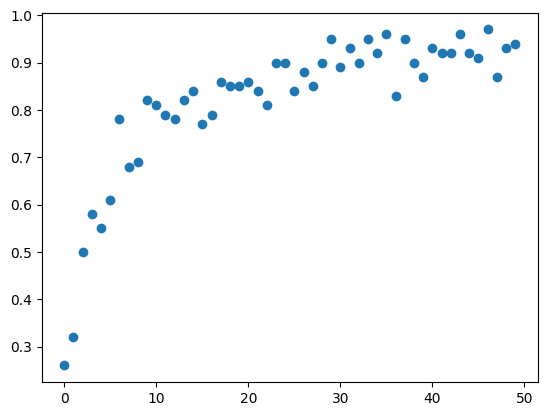

In [288]:
win_ratio = [i.count(1)/len(i) for i in win_ratio_list]
print(len(win_ratio))
plt.scatter(np.arange(len(win_ratio)),win_ratio)
plt.show()

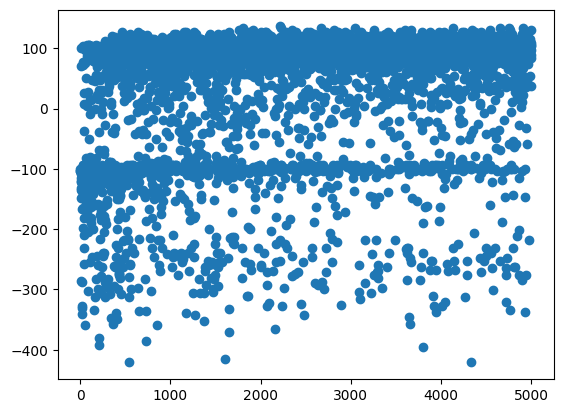

In [290]:
plt.scatter(np.arange(len(total_reward_list)),total_reward_list)
plt.show()

In [291]:
total_reward_list = study(q_table,nRows=nRows,nCols=nCols,nPowers=nPowers,nMines=nMines,showMode=True)

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🔥 🔥 ⬜ 🈺 💣
⬜ 🔥 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🔥 🔥 ⬜ 🐢 💣
⬜ 🔥 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🔥 🔥 ⬜ 🈺 💣
⬜ 🔥 ⬜ ⬜ 🐢 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🔥 🔥 ⬜ 🈺 💣
⬜ 🔥 ⬜ ⬜ ⬛ 🐢
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🔥 🔥 ⬜ 🈺 💣
⬜ 🔥 ⬜ ⬜ 🐢 ⬛
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🔥 🔥 ⬜ 🈺 💣
⬜ 🔥 ⬜ 🐢 ⬛ ⬛
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🔥 🔥 ⬜ 🈺 💣
⬜ 🔥 🐢 ⬛ ⬛ ⬛
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🔥 🔥 ⬜ 🈺 💣
⬜ 🐢 ⬛ ⬛ ⬛ ⬛
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ 🐢 🔥 ⬜ 🈺 💣
⬜ ⬛ ⬛ ⬛ ⬛ ⬛
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🚪 ⬜ ⬜ ⬜
⬜ ⬛ 🐢 ⬜ 🈺 💣
⬜ ⬛ ⬛ ⬛ ⬛ ⬛
⬜ ⬜ ⬜ ⬜ ⬜ 💣

⬜ ⬜ 🔥 🔥 ⬜ 🔥
⬜ ⬜ ⬜ 💣 🔥 🔥
⬜ 💣 🐢 ⬜ ⬜ ⬜
⬜ ⬛ ⬛ ⬜ 🈺 💣
⬜ ⬛ ⬛ ⬛ ⬛ ⬛
⬜ ⬜ ⬜ ⬜ ⬜ 💣

WIN!



In [292]:
print(q_table)

[[-1.15862263e+00 -2.16312016e+00 -1.48404243e+00  2.89908043e+00]
 [-1.43279446e+00 -2.45753952e+00  1.89679832e+00 -2.59743152e+00]
 [ 0.00000000e+00 -4.50000000e-01  0.00000000e+00  7.51019889e+01]
 ...
 [-1.35991549e+01 -1.35797277e+01 -1.39901829e+01 -2.75065000e+01]
 [-1.38719200e+01 -1.48085611e+01 -1.32944646e+01 -1.00000000e+05]
 [-1.46383630e+01 -1.44396085e+01 -1.41889940e+01 -1.37057015e+01]]
